<div class="alert alert-block alert-info">
Last updated: 01/30/2024

# Model Evaluation Framework
    
This notebook attempts to provide a systematic approach for large language model evaluation, starting from a given business problem.

Evaluating LLMs is a complex task. While there are benchmarks (e.g. https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard or https://crfm.stanford.edu/helm/latest/)
 available that provide a general view of how a particular LLM would perform in some common NLP tasks, most of evaluation frameworks/approaches are still evolving and none of them cover all aspects. It is important to understand which benchmark is the most relevant to a given use case, and to be mindful of social aspects, and ultimately to evaluate LLMs against the data of your specific use case.
    
# Business problem
Let's assume a financial analyst wants to use financial statements (balance sheets, income statements, operational reports, annual reports) to better understand the financial strength of a company to help assess risk and guide future investment decisions.

To do this efficiently they need to extract information from these documents which consist largely of unstructured text.
This notebook focuses on Amazon's annual report, but the this approach can easily be adopted to other documents and an entire corpus of documents.

# Solution architecture
<img src="https://d3q8adh3y5sxpk.cloudfront.net/meetingrecordings/modelevaluation/architecture.png" alt="LLM selection process" width="900" height="550">

There are various options for you to choose from in this process:

1) Embeddings: Currently we are using amazon.titan-embed-text-v1, but there are many other embedding models available. 
2) Text Splitter: We used TokenTextSplitter from langchain. Other supported options within langchain are CharacterTextSplitter, RecursiveCharacterTextSplitter, or RecursiveCharacterTextSplitter. Which Splitter works best will vary based on your use case and source data types. In addition there are other libraries like unstructured or eparse available that can further improve retrieval relevance.
3) Vector Store: We used OpenSearch Serverless as our vector database to store embeddings. And while there are many vector databases available, you typically don't need a dedicated vector database. You can leverage a database that already hosts your data and supports vetor search such as PG Vector with RDS or OpenSearch. Data gravity is definitely a strong decision factor.  
4) Retrievers: OpenSearch VectorStoreRetriever using KNN for similarity search. In general to retrieve text, there are two search types: “similarity” or “mmr”. search_type="similarity" uses similarity search. The retriever selects text chunk vectors that are most similar to the question vector. search_type="mmr" uses the maximum marginal relevance search where it optimizes for similarity to query AND diversity among selected documents.
5) Chain Type: The default chain_type="stuff" uses ALL of the text from the documents in the prompt. This might work fine for information extraction within one document, but will not work for information extraction from very large documents or a large corpus of documents. This is where the "map_reduce" chain type comes in. map_reduce separates texts into batches and feeds each batch with the question to the LLM separately, and comes up with the final answer based on the answers from each batch. In contrast the "refine" chain type separates texts into batches, feeds the first batch to LLM, and feeds the answer and the second batch to LLM. It refines the answer by going through all the batches. And lastly, "map-rerank"  separates texts into batches, feeds each batch to LLM, returns a score of how fully it answers the question, and comes up with the final answer based on the high-scored answers from each batch.
6) Prompt Template: In addition to the model size, model type (instruct, chat, light, instant), precision (fp32, fp16), and quantization itself and the options referenced above, there are other variables that impact the response of an LLM, such as:<br>
 Model parameters: Maximum tokens, temperature, top-p, top-k, and frequency penalty<br>
 User prompt: Changing even a single word or punctuation may result in vastly different responses<br>
 Prompt template: Determines tone, tenor, pace, mood, voice, syntax, diction, format, and length of response and helps enforce the use of the supplied contextual reference


# Evaluation

There are numerous evaluation methods and metrics available, and which one you want to consider will depend on the use case. For example for text summarization, ROUGE or a Judge approach are quite common. Given that the focus of this notebook is an information extraction use case, we will focus on the below evaluation methods and metrics.

1) Visualize results for human review
2) Calculate Jaccard Similarity scores of LLM responses compared to Ground Truth 
3) Calculate Cosine Similarity scores of LLM responses compared to Ground Truth
4) Perform a qualitative assessment of the responses using Claude-as-a-Judge

In [ ]:
# install dependencies
%pip install --force-reinstall -r requirements.txt

In [26]:
# restart kernel to ensure proper version of libraries is loaded
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
restartkernel()

In [27]:
# review requirements.txt for reference if needed
!pip list | grep -E "awscli|boto3|botocore|langchain|langsmith|plotly|tiktoken|nltk|python-dotenv|xmltodict|requests-aws4auth|pypdf|opensearch-py|sagemaker"


awscli                    1.32.19
boto3                     1.34.19
botocore                  1.34.19
langchain                 0.1.0
langchain-community       0.0.18
langchain-core            0.1.19
langsmith                 0.0.83
mypy-boto3-bedrock        1.34.0
nltk                      3.8.1
opensearch-py             2.4.2
plotly                    5.9.0
pypdf                     3.17.4
python-dotenv             1.0.0
requests-aws4auth         1.2.3
sagemaker                 2.203.1
tiktoken                  0.5.2
xmltodict                 0.13.0

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [28]:
# load environment variables 
import boto3
import os
import botocore
from botocore.config import Config
import langchain
import sagemaker
import pandas as pd

from langchain.llms.bedrock import Bedrock
from langchain.llms import SagemakerEndpoint
from langchain.llms.sagemaker_endpoint import LLMContentHandler
from typing import Dict

import json
import requests
import csv
import time
import pandas as pd
import nltk
import sys

from langchain.llms import Bedrock
from dotenv import load_dotenv, find_dotenv

# loading environment variables that are stored in local file dev.env
load_dotenv(find_dotenv('dev.env'),override=True)

session = sagemaker.Session()
bucket = session.default_bucket()


os.environ['OPENSEARCH_COLLECTION'] = os.getenv('OPENSEARCH_COLLECTION')

os.environ['AWS_ACCESS_KEY'] = os.getenv('AWS_ACCESS_KEY')
os.environ['AWS_SECRET_TOKEN'] = os.getenv('AWS_SECRET_TOKEN')
os.environ['REGION'] = os.getenv('REGION')

# optional for observability (more information at https://langsmith.com/)
os.environ['LANGCHAIN_ENDPOINT'] = os.getenv('LANGCHAIN_ENDPOINT')
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_PROJECT'] = os.getenv('LANGCHAIN_PROJECT')
os.environ['LANGCHAIN_TRACING_V2'] = os.getenv('LANGCHAIN_TRACING')
os.environ["LANGCHAIN_TRACING"]="false"
os.environ["LANGCHAIN_SESSION"] = "rag-system-eval"

# Initialize Bedrock runtime
config = Config(
   retries = {
      'max_attempts': 8
   }
)
bedrock_runtime = boto3.client(
        service_name="bedrock-runtime",
        config=config
)

In [ ]:
# verify that you have access to Bedrock models
## if you don't have access, review https://us-east-1.console.aws.amazon.com/bedrock/home?region=us-east-1#/modelaccess

bedrock_client = boto3.client(service_name="bedrock")
bedrock_client.list_foundation_models()

<img src="https://d3q8adh3y5sxpk.cloudfront.net/meetingrecordings/modelevaluation/Slide1.jpeg" alt="LLM selection process" width="900" height="550">

# 1) Quick short listing
Based on the LLM capabilties select a dozen models for a small test 

<img src="https://d3q8adh3y5sxpk.cloudfront.net/meetingrecordings/modelevaluation/Slide2.jpeg" alt="LLM capabilities" width="900" height="550">

### For this example we selected 3 LLMs from Amazon Bedrock, each with unique properties and capabilities.
1) Claude-V2
2) Cohere Command
3) Llama2 13B

In [30]:
## 1a. Initialize llm01 = Claude-v2
inference_modifier = {
    "max_tokens_to_sample": 545,
    "temperature": 0,
    "stop_sequences": ["\n\nHuman"],
}
LLM_01_NAME= "anthropic.claude-v2"
llm01 = Bedrock(
    model_id=LLM_01_NAME,
    model_kwargs=inference_modifier
)

In [31]:
## 1b. Initialize Cohere Command
inference_modifier = { 
    "max_tokens": 545,
    "temperature": 0,    
}
LLM_02_NAME= "cohere.command-text-v14"
llm02 = Bedrock(
    model_id=LLM_02_NAME,
    model_kwargs=inference_modifier
)

In [32]:
## 1c. Initialize Llama
inference_modifier = { 
    "max_gen_len": 545,
    "top_p": 0.9, 
    "temperature": 0,    
}
LLM_03_NAME= "meta.llama2-13b-chat-v1"
llm03 = Bedrock(
    model_id=LLM_03_NAME,
    model_kwargs=inference_modifier
)

In [33]:
# 1d. Start with a simple example - no prompt template or RAG, just passing the prompts below directly into the LLMs
from langchain import LLMChain, HuggingFaceHub, Prompt
from langchain.model_laboratory import ModelLaboratory

llms = [
    llm01,
    llm02,
    llm03
]

test_prompts = [ "What are the three main business units of the company?",
    "What were the company's key areas of investment?",
    "What is the single most important risk the company faces in the next year?"]

model_lab = ModelLaboratory.from_llms(llms)

for question in test_prompts:
    prompt = f"""
    Amazon operates three main business segments: North America retail sales, International retail sales, and Amazon Web Services ("AWS"). 

    Risk Factors:
    - Intense competition globally in all business areas - Amazon competes with various companies including physical retailers, e-commerce companies, technology companies, device makers, digital content creators, delivery/logistics providers, and more. 
    - International expansion brings regulatory, infrastructure, and operational risks. Amazon must comply with complex regulations abroad and faces limitations related to infrastructure, local business practices, laws, and legal liability.
    - Demand fluctuation strains operations. Amazon's business sees seasonal sales spikes that test fulfillment capacity. Failure to meet demand can significantly impact sales.
    - Reliance on sellers exposes Amazon to fraud risk. Amazon could face liability for seller violations of policies or fraud. 
    - Protecting IP is challenging. Amazon relies on IP protections globally but enforcement is difficult. Others claim Amazon infringes their IP rights through litigation. 
    - Foreign exchange fluctuations impact results. Amazon has extensive international operations and holds foreign cash, so currency changes affect financials.
    - Rapid expansion strains resources. Adding employees, products/services and infrastructure complexity taxes Amazon's resources. 
    - Accounting requires estimates. Financial reporting relies on certain estimates that may prove incorrect over time.
    - Competitive hiring is critical. Amazon needs to attract and retain technical and executive talent in a tight labor market.
    - Acquisition integration is difficult. Adding companies brings risks during integration and may not meet financial expectations.
    - Security threats bring business risk. Amazon faces cyber attacks and threats requiring ongoing security investments.
    - Lawsuits and claims may arise. Amazon faces litigation, investigations, and other claims that could result in damages.

    Key areas of investment: devices, digital content, international physical/digital retail expansion, AWS growth, advertising, supply chain, and emerging areas like autonomous vehicles.

    Given the above information, answer the following question:
    """ + question
    
    model_lab.compare(prompt)

Input:

    Amazon operates three main business segments: North America retail sales, International retail sales, and Amazon Web Services ("AWS"). 

    Risk Factors:
    - Intense competition globally in all business areas - Amazon competes with various companies including physical retailers, e-commerce companies, technology companies, device makers, digital content creators, delivery/logistics providers, and more. 
    - International expansion brings regulatory, infrastructure, and operational risks. Amazon must comply with complex regulations abroad and faces limitations related to infrastructure, local business practices, laws, and legal liability.
    - Demand fluctuation strains operations. Amazon's business sees seasonal sales spikes that test fulfillment capacity. Failure to meet demand can significantly impact sales.
    - Reliance on sellers exposes Amazon to fraud risk. Amazon could face liability for seller violations of policies or fraud. 
    - Protecting IP is challengi

If you are looking for a no-code option to compare prompts, please refer to SageMaker Canvas (https://aws.amazon.com/about-aws/whats-new/2023/10/amazon-sagemaker-canvas-content-information-extraction/), which provides a UI to easily compare different LLMs and their respective outoutput visually.

# 2) use case specific benchmark

Now after quickly testing the shortlisted LLMs, let's take the top 3 LLMs based on our initial results and LLM capabilities and perform a use case specific benchmark.

<img src="https://d3q8adh3y5sxpk.cloudfront.net/meetingrecordings/modelevaluation/Slide3.jpeg" alt="GeneratePrompts" width="900" height="550">

For our use case we happen to have labeled ground truth data which we can use for our test. Thus we can leverage classic ML-metrics to evaluate the performance of the different LLM pipelines.

In [35]:
## 2a. download ground truth dataset and insert into promptcatalog
import xmltodict
url = 'https://d3q8adh3y5sxpk.cloudfront.net/rageval/qsdata_20.xml'

# Send an HTTP GET request to download the file
response = requests.get(url)

# Check if the request was successful (HTTP status code 200)
if response.status_code == 200:        
    xml_data = xmltodict.parse(response.text)
    
# Convert the dictionary to a Pandas DataFrame
qa_dataset = pd.DataFrame(xml_data['data']['records'])

table_name = 'promptcatalog'
prompts = []
for row in qa_dataset.itertuples():
    item = {
        'prompt': str(row[1]['Question']),
        'context': str(row[1]['Context']),
        'output': str(row[1]['Answer']['question_answer']),
        'evaluationmetric': 'Accuracy'
    }
    prompts.append(item)

# example prompt
print(prompts[0])

{'prompt': "Who is Amazon's Senior Vice President and General Counsel?", 'context': 'Available Information\nOur investor relations website is amazon.com/ir and we encourage investors to use it as a way of easily finding information about us. We promptly make available on this website, free of charge, the reports that we file or furnish with the Securities and Exchange Commission (â\x80\x9cSECâ\x80\x9d), corporate governance information (including our Code of Business Conduct and Ethics), and select press releases.\nExecutive Officers and Directors\nThe following tables set forth certain information regarding our Executive Officers and Directors as of January 25, 2023:\nInformation About Our Executive Officers\nName Age Position\nJeffrey P. Bezos. Mr. Bezos founded Amazon.com in 1994 and has served as Executive Chair since July 2021. He has served as Chair of the Board since 1994 and served as Chief Executive Officer from May 1996 until July 2021, and as President from 1994 until June 1

In [36]:
## 2b. download context / Amazon annual report
import numpy as np
import pypdf
from langchain.text_splitter import CharacterTextSplitter, TokenTextSplitter, RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader, PyPDFDirectoryLoader
from urllib.request import urlretrieve

os.makedirs("data", exist_ok=True)
files = [ "https://d3q8adh3y5sxpk.cloudfront.net/rageval/AMZN-2023-10k.pdf"]
for url in files:
    file_path = os.path.join("data", url.rpartition("/")[2])
    urlretrieve(url, file_path)
    

loader = PyPDFDirectoryLoader("./data/")
documents = loader.load()

In [37]:
## 2c. Split documents into smaller chunks 
### Compare results/impact of Character split and TokenTextSplitter

token_text_splitter = TokenTextSplitter(chunk_size=500, chunk_overlap=100)
#char_text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

token_text_list = token_text_splitter.split_documents(documents)
#char_text_list = char_text_splitter.split_documents(documents)
    
print("TokenTextSplitter split documents in to " + str(len(token_text_list)) + " chunks.\n")
#print("CharacterTextSplitter split documents in to " + str(len(char_text_list)) + " chunks.\n")

TokenTextSplitter split documents in to 354 chunks.



In [38]:
## 2d. create vector store (OpenSearch Serverless)
### Connect to OpenSearchServerless
import time
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth

host = os.environ['OPENSEARCH_COLLECTION']  # serverless collection endpoint, without https://
region = os.environ['REGION']  # e.g. us-east-1

service = 'aoss'
credentials = boto3.Session().get_credentials()
auth = AWSV4SignerAuth(credentials, region, service)

# create vector database (OpenSearch Serverless) if it does not exist yet
if host == '':
    print('creating collection')
    vector_store_name = 'rag-eval'
    encryption_policy_name = "rag-eval-ep"
    network_policy_name = "rag-eval-np"
    access_policy_name = 'rag-eval-ap'
    identity = boto3.client('sts').get_caller_identity()['Arn']

    aoss_client = boto3.client('opensearchserverless')

    security_policy = aoss_client.create_security_policy(
        name = encryption_policy_name,
        policy = json.dumps(
            {
                'Rules': [{'Resource': ['collection/' + vector_store_name],
                'ResourceType': 'collection'}],
                'AWSOwnedKey': True
            }),
        type = 'encryption'
    )

    network_policy = aoss_client.create_security_policy(
        name = network_policy_name,
        policy = json.dumps(
            [
                {'Rules': [{'Resource': ['collection/' + vector_store_name],
                'ResourceType': 'collection'}],
                'AllowFromPublic': True}
            ]),
        type = 'network'
    )

    collection = aoss_client.create_collection(name=vector_store_name,type='VECTORSEARCH')

    while True:
        status = aoss_client.list_collections(collectionFilters={'name':vector_store_name})['collectionSummaries'][0]['status']
        if status in ('ACTIVE', 'FAILED'): 
            print(f'new collection {vector_store_name} created')
            break
        time.sleep(10)

    access_policy = aoss_client.create_access_policy(
        name = access_policy_name,
        policy = json.dumps(
            [
                {
                    'Rules': [
                        {
                            'Resource': ['collection/' + vector_store_name],
                            'Permission': [
                                'aoss:CreateCollectionItems',
                                'aoss:DeleteCollectionItems',
                                'aoss:UpdateCollectionItems',
                                'aoss:DescribeCollectionItems'],
                            'ResourceType': 'collection'
                        },
                        {
                            'Resource': ['index/' + vector_store_name + '/*'],
                            'Permission': [
                                'aoss:CreateIndex',
                                'aoss:DeleteIndex',
                                'aoss:UpdateIndex',
                                'aoss:DescribeIndex',
                                'aoss:ReadDocument',
                                'aoss:WriteDocument'],
                            'ResourceType': 'index'
                        }],
                    'Principal': [identity],
                    'Description': 'Easy data policy'}
            ]),
        type = 'data'
    )

    host = collection['createCollectionDetail']['id'] + '.' + os.environ.get("AWS_DEFAULT_REGION", None) + '.aoss.amazonaws.com:443'
    host = host.split(":")[0]
    print(f'new aoss host: {host}')

aospy_client = OpenSearch(
    hosts=[{'host': host, 'port': 443}],
    http_auth=auth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    pool_maxsize=20,
)
print(f'aospy client:{aospy_client}')

aospy client:<OpenSearch([{'host': 'lx0j8y3mu9ht6r5xv7za.us-east-1.aoss.amazonaws.com', 'port': 443}])>


In [39]:
## 2e. Create in Amazon Opensearch Service vector index for langchain

knn_index = {
    "settings": {
        "index.knn": True,
        
    },
    "mappings": {
        "properties": {
            "vector_field": {
                "type": "knn_vector",
                "dimension": 1536,
                "store": True
            },
            "text": {
                "type": "text",
                "store": True
            },
        }
    }
}

index_name = "rag-system-eval"
try:
    aospy_client.indices.delete(index=index_name)
    aospy_client.indices.create(index=index_name,body=knn_index,ignore=400)
    aospy_client.indices.get(index=index_name)
except:
    print(f'Index {index_name} not found. Creating index on OpenSearch.')
    aospy_client.indices.create(index=index_name,body=knn_index)
    aospy_client.indices.get(index=index_name)

In [40]:
## 2f. Use Titan Embeddings Model to generate embeddings

from langchain.embeddings import BedrockEmbeddings
from langchain.llms.bedrock import Bedrock

bedrock_embeddings = BedrockEmbeddings(client=bedrock_runtime)

In [41]:
## 2g.Insert embeddings into OpenSearch index
### For Serverless, please note is_aoss=True setting

from langchain.vectorstores import OpenSearchVectorSearch

full_opensearch_endpoint = 'https://' + os.environ['OPENSEARCH_COLLECTION']

vector_store=OpenSearchVectorSearch.from_documents(
        index_name = index_name,
        documents=token_text_list,
        embedding=bedrock_embeddings,
        opensearch_url=full_opensearch_endpoint,
        http_auth=auth,
        use_ssl=True,
        verify_certs=True,
        connection_class=RequestsHttpConnection,
        timeout=60*3,
        bulk_size=1000,
        is_aoss=True
    )
retriever = vector_store.as_retriever()

In [50]:
## 2h. validate load
res = aospy_client.search(index=index_name, body={"query": {"match_all": {}}})
print("Records found: %d." % res['hits']['total']['value'])

Records found: 0.


In [51]:
## 2i. Helper function to retrieve specify specific LLM and Prompt Template
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

def retrieve_model_qa_response(target_llm, input_prompt, return_source, query):
    qa = RetrievalQA.from_chain_type(
            llm=target_llm,
            chain_type="stuff",
            retriever=retriever,
            return_source_documents=return_source,
            chain_type_kwargs = {"prompt": input_prompt}
        ).invoke(query)
    return qa

### Claude prompt template
prompt_template_claude_1 = """
        Human: 
        You are a helpful, respectful, and honest assistant, dedicated to providing valuable and accurate information.

        Assistant:
        Understood. I will provide information based on the context given, without relying on prior knowledge.

        Human:
        If you don't see answer in the context just reply "not available" in XML tags.

        Assistant:
        Noted. I will respond with "not available" if the information is not available in the context.

        Human:
        Now read this context and answer the question and return the answer inside <question_answer></question_answer> XML tags. 
        {context}

        Assistant:
        Based on the provided context above and information from the retriever source, I will provide the answer in  and return it inside <question_answer></question_answer> XML tags to the below question
        {question}
        """

PROMPT_CLAUDE_1 = PromptTemplate(
    template=prompt_template_claude_1, input_variables=["question", "context"]
)

### Llama2 prompt template
prompt_template_llama_1 = """
        [INST]
        You are a helpful, respectful, and honest assistant, dedicated to providing valuable and accurate information.
        [/INST]

        Understood. I will provide information based on the context given, without relying on prior knowledge.

        [INST]
        If you don't see answer in the context just reply "not available" in XML tags.
        [/INST]

        Noted. I will respond with "not available" if the information is not available in the context.

        [INST]
        Now read this context and answer the question and return the answer inside <question_answer></question_answer> XML tags. 
        {context}
        [/INST]

        Based on the provided context above and information from the retriever source, I will provide the answer in  and return it inside <question_answer></question_answer> XML tags to the below question
        {question}
        """
PROMPT_LLAMA_1 = PromptTemplate(
    template=prompt_template_llama_1, input_variables=["question", "context"]
)


### Cohere Command prompt template
prompt_template_command_1 = """
        Human: 
        You are a helpful, respectful, and honest assistant, dedicated to providing valuable and accurate information.

        Assistant:
        Understood. I will provide information based on the context given, without relying on prior knowledge.

        Human:
        If you don't see answer in the context just reply "not available" in XML tags.

        Assistant:
        Noted. I will respond with "not available" if the information is not available in the context.

        Human:
        Now read this context and answer the question and return the answer inside <question_answer></question_answer> XML tags. 
        {context}

        Assistant:
        Based on the provided context above and information from the retriever source, I will provide the answer in  and return it inside <question_answer></question_answer> XML tags to the below question
        {question}
        """
PROMPT_COMMAND_1 = PromptTemplate(
    template=prompt_template_command_1, input_variables=["question", "context"]
)

In [63]:
## 2j. run all LLMs through qa catalog

promptsdf = pd.DataFrame(prompts)

predictions = []
for llm in llms:
    for row in promptsdf.itertuples():
        query = row.prompt
        
        llm_name = ''
        try:
            llm_name = str(llm.model_id)
        except:
            try:
                llm_name = str(llm.endpoint_name)
            except:
                try:
                    llm_name = str(llm._llm_type)
                except:
                    pass
        
        if llm_name == LLM_01_NAME:
            prompt = PROMPT_CLAUDE_1

        if llm_name == LLM_02_NAME:
            prompt = PROMPT_COMMAND_1

        if llm_name == LLM_03_NAME:
            prompt = PROMPT_LLAMA_1

        result = retrieve_model_qa_response(target_llm=llm,
                                 input_prompt=prompt,
                                 return_source=True,
                                 query=query)

        contexts = []
        for retrievedContext in result["source_documents"]: 
            contexts.append(retrievedContext.page_content)

        predictions.append({
                "query": row.prompt,
                "llm": str(llm_name),
                "output": str(result["result"]),
                "trainingoutput": str(row.output),
                "context": str(contexts),
                "trainingcontext": str(row.context),
                "evaluationmetric": "",
                "score": "",
                "feedback": ""
        })

In [65]:
# export data 
predictions_run_df = pd.DataFrame(predictions)
predictions_run_df.to_csv('./eval_run_predictions.csv', index=False)

<img src="https://d3q8adh3y5sxpk.cloudfront.net/meetingrecordings/modelevaluation/Slide4.jpeg" alt="EvaluatingResults" width="900" height="550">

# Evaluation

## Jaccard Similarity
Jaccard Similarity is a measure of similarity between two asymmetric binary vectors or we can say a way to find the similarity between two sets. It is a common proximity measurement used to compute the similarity of two items, such as two text documents. The index ranges from 0 to 1.

In [66]:
### 3a. LLM evaluation using Jaccard Similarity
print("Grader with Jaccard Similarity Scores")
from typing import Optional

def jaccard_chars(output: str, answer: str) -> float:
    try:
        """Naive Jaccard similarity between two strings."""
        prediction_chars = set(output.strip().lower())
        answer_chars = set(answer.strip().lower())
        intersection = prediction_chars.intersection(answer_chars)
        union = prediction_chars.union(answer_chars)
        return len(intersection) / len(union)
    except:
        return 1
 
def grader(run_input: str, run_output: str, answer: Optional[str]) -> dict:
    """Compute the score and/or label for this run."""
    if answer is None:
        value = "AMBIGUOUS"
        score = 0.5
    else:
        score = jaccard_chars(run_output, answer)
        value = "CORRECT" if score > 0.9 else "INCORRECT"
    return dict(score=score, value=value)
            
string_eval_predictions = []
for prediction in predictions:
        evaluation_result = grader(prediction['query'], prediction['output'], prediction['trainingoutput'])    
        string_eval_predictions.append({
                "query": prediction['query'],
                "llm": prediction['llm'],
                "output": prediction['output'],
                "trainingoutput": prediction['trainingoutput'],
                "context": prediction['context'],
                "trainingcontext": prediction['trainingcontext'],
                "evaluationmetric": "Naive Jaccard similarity between two strings",
                "score": str(evaluation_result['value']),
                "feedback": str(evaluation_result['score']),
            })

table_name = 'llmevaluationresults'
print(string_eval_predictions[1])

Grader with Jaccard Similarity Scores
{'query': "Where are Amazon's international headquarters located?", 'llm': 'anthropic.claude-v2', 'output': "\n<question_answer>\nAmazon's international headquarters are located in Luxembourg.\n</question_answer>", 'trainingoutput': 'Amazon owns and leases corporate headquarters in Washingtonâ\x80\x99s Puget Sound region and Arlington, Virginia.', 'context': "[' software engineers, computer scientists, and other technical staff, and constrained labor markets have\\nincreased competition for personnel across other parts of our business.\\nAs we strive to be Earth’s best employer, we focus on investment and innovation, inclusion and diversity, safety, and engagement to hire and develop the\\nbest talent. We rely on numerous and evolving initiatives to implement these objectives and invent mechanisms for talent development, including competitive\\npay and benefits, flexible work arrangements, and skills training and educational programs such as Amazon

In [67]:
# export data 
jaccard_eval_run_df = pd.DataFrame(string_eval_predictions)
jaccard_eval_run_df.to_csv('./eval_run_jaccard.csv', index=False)

## Cosine Similarity
The smaller the angle between the two vectors, the more similar they are to each other.<br>
A cosine similarity of 1 indicates that the vectors are identical or point in the same direction.<br>
A cosine similarity of -1 indicates that the vectors are diametrically opposed.<br>
A cosine similarity of 0 means the vectors are orthogonal or completely dissimilar.<br>

<img src="https://d3q8adh3y5sxpk.cloudfront.net/meetingrecordings/modelevaluation/CosineSimilarity.webp" alt="GeneratePrompts" width="900" height="550">



In [68]:
### 3b. LLM evaluation using Cosine Similarity
print("Grader with Cosine Similarity Scores")
from typing import Optional
from collections import Counter
import math
from IPython.display import display, HTML
import numpy as np
from numpy.linalg import norm
max_count = 20
num_to_eval = 20

def get_embedding(body, modelId, accept, contentType):
    response = bedrock_runtime.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
    response_body = json.loads(response.get('body').read())
    embedding = response_body.get('embedding')
    return embedding

def cosine_similarity(str1: str, str2: str) -> float:
    modelId = "amazon.titan-embed-text-v1"
    accept = "application/json"
    contentType = "application/json"

    
    doc = {"inputText": str1}
    body = json.dumps(doc)
    embedding1 = get_embedding(body, modelId, accept, contentType)
    sleep_timer=5
    time.sleep(sleep_timer)
    doc = {"inputText": str2}
    body = json.dumps(doc)
    embedding2 = get_embedding(body, modelId, accept, contentType)
    
    cosine_sim = np.dot(embedding2, embedding1) / (norm(embedding2) * norm(embedding1))
    
    return cosine_sim

    
def grader(run_input: str, run_output: str, answer: Optional[str]) -> dict:
    """Compute the score and/or label for this run."""
    if answer is None:
        value = "AMBIGUOUS"
        score = 0.5
    else:
        score = cosine_similarity(run_output, answer)
        value = "CORRECT" if score > 0.9 else "INCORRECT"
    return dict(score=score, value=value)
            
cosine_string_eval_predictions = []
for prediction in predictions:
        evaluation_result = grader(prediction['query'], prediction['output'], prediction['trainingoutput'])    
        cosine_string_eval_predictions.append({
                "query": prediction['query'],
                "llm": prediction['llm'],
                "output": prediction['output'],
                "trainingoutput": prediction['trainingoutput'],
                "context": prediction['context'],
                "trainingcontext": prediction['trainingcontext'],
                "evaluationmetric": "cosine similarity between two strings",
                "score": str(evaluation_result['value']),
                "feedback": str(evaluation_result['score']),
            })

print(cosine_string_eval_predictions[1])

Grader with Cosine Similarity Scores
{'query': "Where are Amazon's international headquarters located?", 'llm': 'anthropic.claude-v2', 'output': "\n<question_answer>\nAmazon's international headquarters are located in Luxembourg.\n</question_answer>", 'trainingoutput': 'Amazon owns and leases corporate headquarters in Washingtonâ\x80\x99s Puget Sound region and Arlington, Virginia.', 'context': "[' software engineers, computer scientists, and other technical staff, and constrained labor markets have\\nincreased competition for personnel across other parts of our business.\\nAs we strive to be Earth’s best employer, we focus on investment and innovation, inclusion and diversity, safety, and engagement to hire and develop the\\nbest talent. We rely on numerous and evolving initiatives to implement these objectives and invent mechanisms for talent development, including competitive\\npay and benefits, flexible work arrangements, and skills training and educational programs such as Amazon 

In [69]:
# export data 
cosine_eval_run_df = pd.DataFrame(cosine_string_eval_predictions)
cosine_eval_run_df.to_csv('./eval_run_cosine.csv', index=False)

In [70]:

def get_embedding(body, modelId, accept, contentType):
    response = bedrock_runtime.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
    response_body = json.loads(response.get('body').read())
    embedding = response_body.get('embedding')
    return embedding

sleep_timer = 5

def get_array_of_embeddings(phrases):
    """
    Get an array of embeddings from a list of summaries.

    Args:
        phrases (list): List of summary texts.

    Returns:
        list: List of embeddings obtained from the models.
    """
    modelId = "amazon.titan-embed-text-v1"
    accept = "application/json"
    contentType = "application/json"

    array_embeddings = []
    for phrase in phrases:
        doc = {"inputText": phrase}
        body = json.dumps(doc)
        embedding = get_embedding(body, modelId, accept, contentType)
        array_embeddings.append(embedding)
        time.sleep(sleep_timer)

    return array_embeddings


cosine_string_eval_predictions_df = pd.DataFrame(cosine_string_eval_predictions)
claude_output = cosine_string_eval_predictions_df[cosine_string_eval_predictions_df['llm'] == LLM_01_NAME]['output']
cohere_output = cosine_string_eval_predictions_df[cosine_string_eval_predictions_df['llm'] == LLM_02_NAME]['output']
lama_output = cosine_string_eval_predictions_df[cosine_string_eval_predictions_df['llm'] == LLM_03_NAME]['output']
gt_output = cosine_string_eval_predictions_df[cosine_string_eval_predictions_df['llm'] == LLM_01_NAME]['trainingoutput']

lama_embeddings = get_array_of_embeddings(lama_output)
cohere_embeddings = get_array_of_embeddings(cohere_output)
claude_embeddings = get_array_of_embeddings(claude_output)
gt_embeddings = get_array_of_embeddings(gt_output)

Calculating Cosine Similarities for information extraction task ...
Cosine Similarity Score for Llama Answers are: [0.66382168 0.70241854 0.89913879 0.3443202  0.81868577 0.86680831
 0.68736098 0.85308475 0.64081982 0.86862942 0.00468327 0.40803362
 0.74747243 0.8752496  0.86613245]
Cosine Similarity Score for Cohere Answers are: [ 0.55690587  0.46015503  0.37384202  0.10221419 -0.03708714  0.25940235
  0.31560206  0.17837728  0.14671803  0.18562606  0.0291328   0.46133933
  0.54051171  0.75959243  0.4913961 ]
Cosine Similarity Score for Claude Answers are: [0.52644405 0.67237915 0.42672316 0.1028449  0.8016349  0.23212622
 0.22306625 0.54434742 0.48990483 0.92027796 0.05613432 0.70243287
 0.74815702 0.93127808 0.93812129]


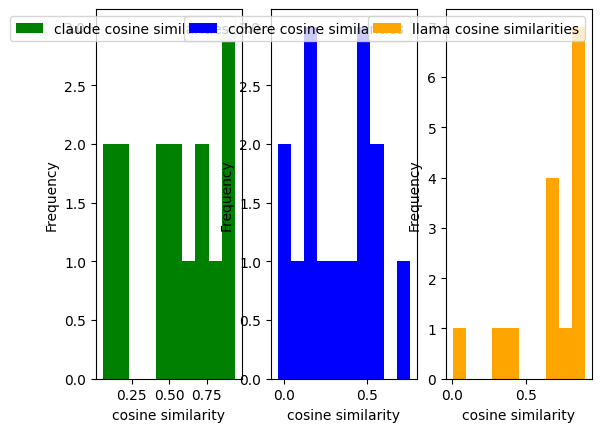

In [71]:
print("Calculating Cosine Similarities for information extraction task ...")
from IPython.display import display, HTML
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

max_count = 19
num_to_eval = 15

lama_gt_cosine_sim = np.empty(num_to_eval)
cohere_gt_cosine_sim = np.empty(num_to_eval)
claude_gt_cosine_sim = np.empty(num_to_eval)

for index in range(num_to_eval):
    lama_gt_cosine_sim[index] = np.dot(
        gt_embeddings[index], lama_embeddings[index]
    ) / (norm(gt_embeddings[index]) * norm(lama_embeddings[index]))

    cohere_gt_cosine_sim[index] = np.dot(
        gt_embeddings[index], cohere_embeddings[index]
    ) / (norm(gt_embeddings[index]) * norm(cohere_embeddings[index]))

    claude_gt_cosine_sim[index] = np.dot(
        gt_embeddings[index], claude_embeddings[index]
    ) / (norm(gt_embeddings[index]) * norm(claude_embeddings[index]))


print(
    f"Cosine Similarity Score for Llama Answers are: {lama_gt_cosine_sim}"
)
print(
    f"Cosine Similarity Score for Cohere Answers are: {cohere_gt_cosine_sim}"
)
print(
    f"Cosine Similarity Score for Claude Answers are: {claude_gt_cosine_sim}"
)

ig, axs = plt.subplots(1, 3)
# plt.subplots_adjust(wspace=0.1)

plt.subplot(1, 3, 1)
plt.hist(claude_gt_cosine_sim, color="green")
plt.legend(["claude cosine similarities"])
plt.xlabel("cosine similarity")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
plt.hist(cohere_gt_cosine_sim, color="blue")
plt.legend(["cohere cosine similarities"])
plt.xlabel("cosine similarity")
plt.ylabel("Frequency")


plt.subplot(1, 3, 3)
plt.hist(lama_gt_cosine_sim, color="orange")
plt.legend(["llama cosine similarities"])
plt.xlabel("cosine similarity")
plt.ylabel("Frequency")
plt.show()

Creating Cosine Similarity heatmap ...


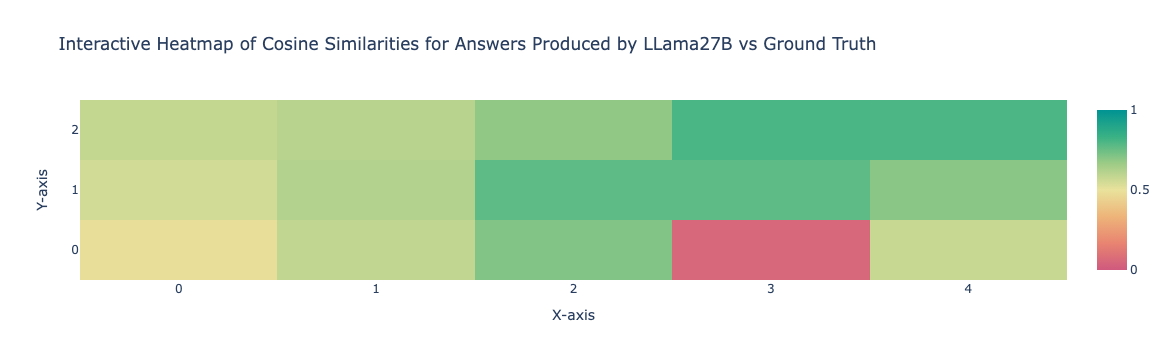

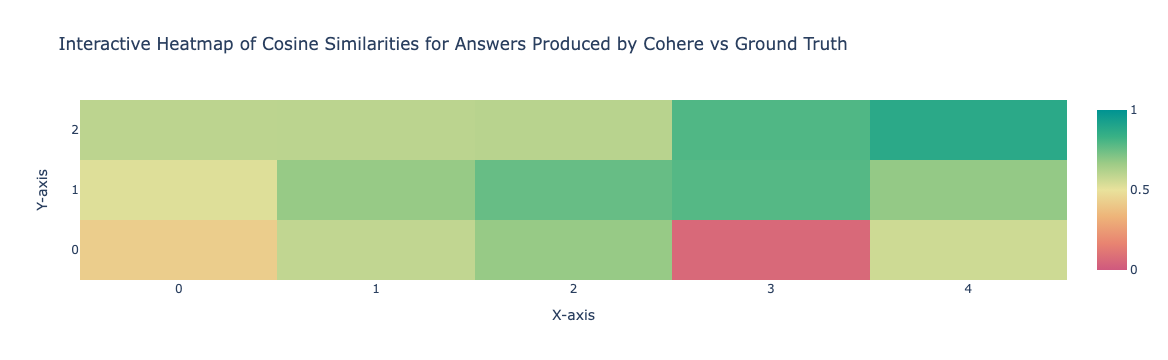

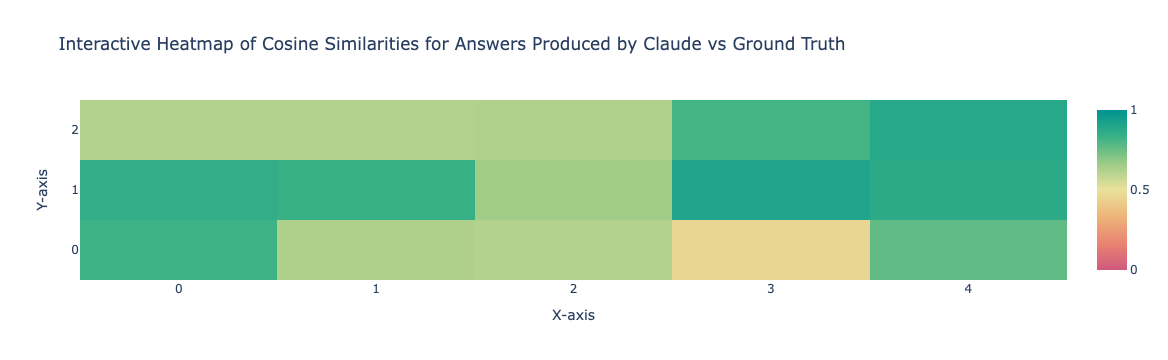

In [38]:
print("Creating Cosine Similarity heatmap ...")
import sympy
import numpy as np

num_questions = 20
num_to_eval = 15

def find_min_factors(number):
    if sympy.isprime(number):
        number += 1

    while sympy.isprime(number):
        number += 1

    factors = []
    for index in range(2, number):
        if number % index == 0:
            factors.append((index, number // index))

    min_factors = min(factors, key=lambda x: abs(x[0] - x[1]))
    return number, min_factors

factors = []
num_to_eval, factors = find_min_factors(num_to_eval)
srows = factors[0]
scols = factors[1]

num_questions, factors = find_min_factors(num_questions)
qrows = factors[0]
qcols = factors[1]


import plotly.graph_objects as go

# Reshape the data into a 2D array (e.g., 4x5 grid)
heatmap_data_cohere = np.array(cohere_gt_cosine_sim).reshape(srows, scols)
heatmap_data_lama = np.array(lama_gt_cosine_sim).reshape(srows, scols)
heatmap_data_claude = np.array(claude_gt_cosine_sim).reshape(srows, scols)

# Create the heatmap figure using plotly
heatmap_fig_cohere = go.Figure(
    data=go.Heatmap(z=heatmap_data_cohere, colorscale="temps_r", zmin=0, zmax=1)
)

heatmap_fig_lama = go.Figure(
    data=go.Heatmap(z=heatmap_data_lama, colorscale="temps_r", zmin=0, zmax=1)
)

heatmap_fig_claude = go.Figure(
    data=go.Heatmap(z=heatmap_data_claude, colorscale="temps_r", zmin=0, zmax=1)
)

# Customize the layout of the figure (optional)
heatmap_fig_cohere.update_layout(
    title="Interactive Heatmap of Cosine Similarities for Answers Produced by Cohere vs Ground Truth",
    xaxis=dict(title="X-axis"),
    yaxis=dict(title="Y-axis"),
)

heatmap_fig_lama.update_layout(
    title="Interactive Heatmap of Cosine Similarities for Answers Produced by LLama27B vs Ground Truth",
    xaxis=dict(title="X-axis"),
    yaxis=dict(title="Y-axis"),
)

heatmap_fig_claude.update_layout(
    title="Interactive Heatmap of Cosine Similarities for Answers Produced by Claude vs Ground Truth",
    xaxis=dict(title="X-axis"),
    yaxis=dict(title="Y-axis"),
)

# Show the interactive heatmap
heatmap_fig_lama.show()
heatmap_fig_cohere.show()
heatmap_fig_claude.show()


# LLM Grader

In [72]:
### 3c. LLM evaluation using a mechanism for LLM-assisted evaluation to compare and score the responses 
### with the help of LLMs using langchain QAEvalChain

os.environ["LANGCHAIN_SESSION"] = "llm-grader"
from langchain.chat_models import BedrockChat
from langchain.evaluation.qa import QAEvalChain
import time
inference_modifier = {
    "max_tokens_to_sample": 545,
    "temperature": 0,
    "top_k": 250,
    "top_p": 1,
    "stop_sequences": ["\n\nHuman"],
}

llm = BedrockChat(model_id="anthropic.claude-v2", model_kwargs=inference_modifier)

eval_chain = QAEvalChain.from_llm(llm)

qa_list = [{'query': item['query'], 'answer': item['trainingoutput']} for item in predictions]

## to avoid read timeouts split qa_list into chunks and execute eval_chain_evaluate function for each chunk with a wait period in betwwen
chunk_size = 50
graded_outputs = []
qa_chunks = [qa_list[i:i + chunk_size] for i in range(0, len(qa_list), chunk_size)]
qa_predictions = [predictions[i:i + chunk_size] for i in range(0, len(predictions), chunk_size)]

i = 0
print(f'Total # of chunks {len(qa_chunks)}')
while i < len(qa_chunks):
    print(f'starting chunk {i}')
    try:
        graded_output_chunk = eval_chain.evaluate(qa_chunks[i], qa_predictions[i], question_key = 'query', prediction_key = 'output')
        graded_outputs.append(graded_output_chunk)
        # wait between each chunk
        time.sleep(60)
    except:
        print('going to next chunk')
        continue
    i+=1

Total # of chunks 2
starting chunk 0


starting chunk 1


In [73]:
### 3d. Store LLM evaluated metrics in llmevaluationresults table
llm_eval_predictions=[]
graded_outputs_flat = [item for sublist in graded_outputs for item in sublist]

for i, eg in enumerate(graded_outputs_flat):
    grade = ''
    try:
        if 'GRADE: INCORRECT' in str(graded_outputs_flat[i]['results']):
            grade = 'INCORRECT'
        else:
            grade = 'CORRECT'  
    except:
        print('failed to extract grade')

    llm_eval_predictions.append({
                "query": predictions[i]['query'],
                "llm": predictions[i]['llm'],
                "output": predictions[i]['output'],
                "trainingoutput": predictions[i]['trainingoutput'],
                "context": predictions[i]['context'],
                "trainingcontext": predictions[i]['trainingcontext'],
                "evaluationmetric": "LLM-assisted evaluation with Claude",
                "score": grade,
                "feedback": str(graded_outputs_flat[i]['results'])
            })

In [74]:
# export data 
llm_eval_run_df = pd.DataFrame(llm_eval_predictions)
llm_eval_run_df.to_csv('./eval_run_llm.csv', index=False)

In [75]:
### 3e. evaluating overall rag system accuracy

# Count the number of CORRECT and INCORRECT evaluations for each LLM and evaluation method
llm_eval_predictions_df = pd.DataFrame(llm_eval_predictions)

# get value of grouby column
llm_eval_predictions_df['llm'] = llm_eval_predictions_df['llm'].str.strip()
llm_eval_predictions_df['CORRECT_Count'] = llm_eval_predictions_df.groupby('llm')['score'].transform(lambda x: (x == 'CORRECT').sum())
llm_eval_predictions_df['INCORRECT_Count'] = llm_eval_predictions_df.groupby('llm')['score'].transform(lambda x: (x == 'INCORRECT').sum())
llm_eval_predictions_df['llm_eval_accuracy'] = llm_eval_predictions_df['CORRECT_Count'] / (llm_eval_predictions_df['CORRECT_Count'] + llm_eval_predictions_df['INCORRECT_Count'])
llm_eval_predictions_df['TOTAL_Count'] = llm_eval_predictions_df['CORRECT_Count'] + llm_eval_predictions_df['INCORRECT_Count']

# remove all columns from dataframe except columns TOTAL_Count, CORRECT_Count, INCORRECT_Count, llm_eval_accuracy
llm_eval_predictions_df = llm_eval_predictions_df[['llm','TOTAL_Count', 'CORRECT_Count', 'INCORRECT_Count', 'llm_eval_accuracy']]

#remove all duplicate rows from llm_eval_predictions_df
llm_eval_predictions_df = llm_eval_predictions_df.drop_duplicates()

# Count the number of CORRECT and INCORRECT evaluations for each LLM and evaluation method
string_eval_predictions_df = pd.DataFrame(string_eval_predictions)

# get value of grouby column
string_eval_predictions_df['llm'] = string_eval_predictions_df['llm'].str.strip()
string_eval_predictions_df['CORRECT_Count'] = string_eval_predictions_df.groupby('llm')['score'].transform(lambda x: (x == 'CORRECT').sum())
string_eval_predictions_df['INCORRECT_Count'] = string_eval_predictions_df.groupby('llm')['score'].transform(lambda x: (x == 'INCORRECT').sum())
string_eval_predictions_df['jaccard_eval_accuracy'] = string_eval_predictions_df['CORRECT_Count'] / (string_eval_predictions_df['CORRECT_Count'] + string_eval_predictions_df['INCORRECT_Count'])
string_eval_predictions_df['avg_jaccard_similarity'] = string_eval_predictions_df.groupby('llm')['feedback'].transform(lambda x: pd.to_numeric(x).mean())
string_eval_predictions_df['TOTAL_Count'] = string_eval_predictions_df['CORRECT_Count'] + string_eval_predictions_df['INCORRECT_Count']

# remove all columns from dataframe except columns TOTAL_Count, CORRECT_Count, INCORRECT_Count, llm_eval_accuracy
string_eval_predictions_df = string_eval_predictions_df[['llm','TOTAL_Count', 'CORRECT_Count', 'INCORRECT_Count', 'jaccard_eval_accuracy','avg_jaccard_similarity']]

#remove all duplicate rows from llm_eval_predictions_df
string_eval_predictions_df = string_eval_predictions_df.drop_duplicates()


# Count the number of CORRECT and INCORRECT evaluations for each LLM and evaluation method
cosine_string_eval_predictions_df = pd.DataFrame(cosine_string_eval_predictions)

# get value of grouby column
cosine_string_eval_predictions_df['llm'] = cosine_string_eval_predictions_df['llm'].str.strip()
cosine_string_eval_predictions_df['CORRECT_Count'] = cosine_string_eval_predictions_df.groupby('llm')['score'].transform(lambda x: (x == 'CORRECT').sum())
cosine_string_eval_predictions_df['INCORRECT_Count'] = cosine_string_eval_predictions_df.groupby('llm')['score'].transform(lambda x: (x == 'INCORRECT').sum())
cosine_string_eval_predictions_df['cosine_eval_accuracy'] = cosine_string_eval_predictions_df['CORRECT_Count'] / (cosine_string_eval_predictions_df['CORRECT_Count'] + cosine_string_eval_predictions_df['INCORRECT_Count'])
cosine_string_eval_predictions_df['avg_cosine_similarity'] = cosine_string_eval_predictions_df.groupby('llm')['feedback'].transform(lambda x: pd.to_numeric(x).mean())
cosine_string_eval_predictions_df['TOTAL_Count'] = cosine_string_eval_predictions_df['CORRECT_Count'] + cosine_string_eval_predictions_df['INCORRECT_Count']

# remove all columns from dataframe except columns TOTAL_Count, CORRECT_Count, INCORRECT_Count, llm_eval_accuracy
cosine_string_eval_predictions_df = cosine_string_eval_predictions_df[['llm','TOTAL_Count', 'CORRECT_Count', 'INCORRECT_Count', 'cosine_eval_accuracy','avg_cosine_similarity']]

#remove all duplicate rows from llm_eval_predictions_df
cosine_string_eval_predictions_df = cosine_string_eval_predictions_df.drop_duplicates()

In [76]:
# show first 4 rows from jaccard_eval_predictions_df
string_eval_predictions_df[['llm','avg_jaccard_similarity']]

,llm,avg_jaccard_similarity
0,anthropic.claude-v2,0.576636
21,cohere.command-text-v14,0.511052
42,meta.llama2-13b-chat-v1,0.630041


In [77]:
# show first 4 rows from cosine_string_eval_predictions_df
cosine_string_eval_predictions_df[['llm','avg_cosine_similarity']]

,llm,avg_cosine_similarity
0,anthropic.claude-v2,0.582510
21,cohere.command-text-v14,0.335644
42,meta.llama2-13b-chat-v1,0.664545


In [78]:
# show first 4 rows from llm_eval_predictions_df
llm_eval_predictions_df.head(4)

,llm,TOTAL_Count,CORRECT_Count,INCORRECT_Count,llm_eval_accuracy
0,anthropic.claude-v2,21,19,2,0.904762
21,cohere.command-text-v14,21,17,4,0.809524
42,meta.llama2-13b-chat-v1,21,17,4,0.809524


LLM-assisted evaluation provides significant better evaluation results compared to string evaluation. Yet it does not provide insights into Faithfulness, Context Precision,Context Recall, Answer Relevancy,or Aspect Critiques), which would also be helpful for a RAG use case like this. This is where libraries like RAGAS and langsmith can be helpful.

llm name: anthropic.claude-v2
llm name: cohere.command-text-v14
llm name: meta.llama2-13b-chat-v1


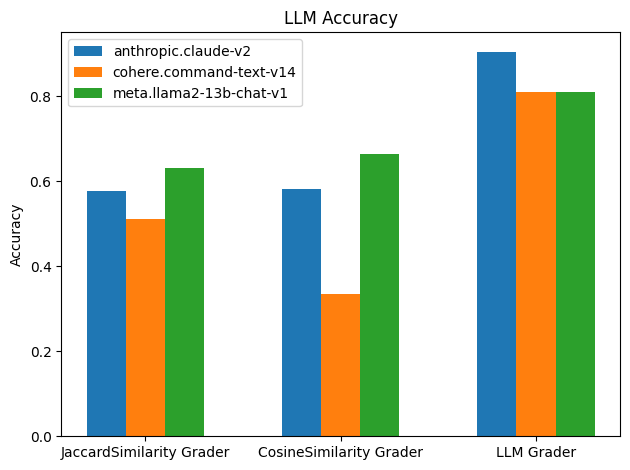

In [79]:
### 3f. visualize RAG system accuracy
# plot each row' accuracy column in overall_accuracy with matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

categories = ["JaccardSimilarity Grader", "CosineSimilarity Grader", "LLM Grader"]
dataprep = []
for index, row in llm_eval_predictions_df.iterrows():
    llm_name = row['llm']
    print(f'llm name: {llm_name}')
    result_df = string_eval_predictions_df[string_eval_predictions_df['llm'] == llm_name]
    value = result_df.loc[index, 'avg_jaccard_similarity']
    result2_df = cosine_string_eval_predictions_df[cosine_string_eval_predictions_df['llm'] == llm_name]
    value2 = result2_df.loc[index, 'avg_cosine_similarity']
    
    dataprep.append([llm_name, pd.to_numeric(value), pd.to_numeric(value2), pd.to_numeric(row['llm_eval_accuracy'])])

data = {
    'EvaluationMethod': categories,
    dataprep[0][0] : dataprep[0][1:],
    dataprep[1][0]: dataprep[1][1:],
    dataprep[2][0]: dataprep[2][1:]
}

df = pd.DataFrame(data)

# Set the width of the bars and the number of series
num_series = len(df.columns) - 1  # Subtract 1 to exclude the 'Category' column
bar_width = 0.2
bar_positions = np.arange(len(df))

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each series
for i, col in enumerate(df.columns[1:]):
    offset = (i - (num_series - 1) / 2) * bar_width
    ax.bar(bar_positions + offset, df[col], width=bar_width, label=col)

# Set x-axis labels
ax.set_xticks(bar_positions)
ax.set_xticklabels(df['EvaluationMethod'])

# Labeling and legend
#ax.set_xlabel('Model Evaluation')
ax.set_ylabel('Accuracy')
ax.set_title('LLM Accuracy')
ax.legend()

# Show the chart
plt.tight_layout()  # Optional: Adjust layout for better spacing
plt.show()

<img src="https://d3q8adh3y5sxpk.cloudfront.net/meetingrecordings/modelevaluation/Slide5.jpeg" alt="EvaluatingResults" width="900" height="550">

<p>Everything we went through in this notebook so far focused on Precision/Accuracy, yet speed and cost are two other important dimensions for model evaluation. </p>

### Speed
Amazon SageMaker provides Inference Recommender (https://docs.aws.amazon.com/sagemaker/latest/dg/inference-recommender.html), which automates load testing and model tuning across SageMaker ML instances. You can use Inference Recommender to deploy your model to an inference endpoint that delivers the best performance at the lowest cost. Inference Recommender helps you select the best instance type and configuration (such as instance count, container parameters, and model optimizations). 
 
Given that this is information extraction and is not part of a real-time workflow, speed is 3rd / no priority in this model selection. 
 
### Cost
All three LLMs are now available via Amazon Bedrock. For latest pricing information, please refer to  
https://aws.amazon.com/bedrock/pricing/. 
 
While Llama2 is available via Amazon Bedrock, it is also available via Amazon SageMaker (including smaller versions like Llama2 7B), which can make a difference at scale. For example assuming 1 million documents, a Llama2 7B model runtime would be 57.8 days (=5*1000000/60/60/24) with a total cost of 2108 dollar compared to 17850 dollar for Claude or 8750 dollar for Command on Amazon Bedrock.
</p>

# What can be improved in the evaluation strategy?
- Use other metrics than accuracy. Maybe a semantic similarity metric like the one proposed in "Semantic Answer Similarity for Evaluating Question Answering Models" (arXiv:2108.06130).

- Evaluate each component of the system in isolation. For example evaluate the retrieval system/strategy separately and not just the entire pipeline as a whole. You could evaluate the retrieval system by saving the chunks that were used/are relevant for the actual answer alongside with the questions and answers in the evaluation dataset. Then you can compare/evaluate which top k chunks are being selected during the evaluation and whether or not the retriever selected a chunk with the source truth and at which rank and experiment with the different retriever options and chain types.

- Explore chains/parsers/tools in conjunction with LLMs, e.g. contextual compressors & filters in RAG, eparse (https://github.com/ChrisPappalardo/eparse), unstructured (https://github.com/Unstructured-IO/unstructured), and/or Kor (https://eyurtsev.github.io/kor/tutorial.html)

- Instead of Claude V2/LLama use a different LLM as Grader, e.g. Falcon 180B, to avoid/minimize bias in the evaluation

- Leverage LLM evaluation frameworks such as langsmith, ragas, langtest etc

- Incorporate other dimensions such as performance/latency and cost in more detail into the evaluation as well to derive at a cost performance benchmark

# Conclusion
- LLMs are here to stay, and the evaluation of LLMs is still evolving, with new research and tooling being released on a regular basis.
- While this notebook focused on LLM accuracy, it also highlights the importance of other dimesions such as cost and latency, and outlines a practical approach to large language model evaluation.

## NEW
### SageMaker Clarify FM Eval
Use the FMEval library to evaluate the RAG systems on factual knowledge.

In [81]:
# 1. Verify libraries dependencies
## if you are on mac and get an error try the below workaround to fix the Rust installation on MacOS:
## curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh
## rustup install 1.72.1
## rustup default 1.72.1-aarch64-apple-darwin
## rustup toolchain remove stable-aarch64-apple-darwin
## rm -rf $HOME/.rustup/toolchains/stable-aarch64-apple-darwin
## mv $HOME/.rustup/toolchains/1.72.1-aarch64-apple-darwin $HOME/.rustup/toolchains/stable-aarch64-apple-darwin

!pip list | grep -E "fmeval|pandas"

fmeval                    0.3.0
pandas                    2.1.3

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [82]:
import pandas as pd
predictions_run_df = pd.read_csv('eval_run_predictions.csv')

In [95]:

import re

# Function to remove XML tags
def remove_xml_tags(text):
    clean_text = re.sub(r'<[^>]+>', '', text)
    return clean_text

# create eval dataset
eval_df = predictions_run_df

# remove unnecessary columns
eval_df = eval_df.drop(['trainingcontext', 'context','evaluationmetric', 'feedback','score'], axis=1)

# Apply the function to the column
eval_df['output'] = eval_df['output'].apply(remove_xml_tags)

# create separate dataframe for each llm
claude_eval_df = eval_df[eval_df['llm'] == 'anthropic.claude-v2']
cohere_eval_df = eval_df[eval_df['llm'] == 'cohere.command-text-v14']
llama_eval_df = eval_df[eval_df['llm'] == 'meta.llama2-13b-chat-v1']

# Output in JSONL format
claude_eval_df.to_json(orient='records', lines=True)
filepath = "rag_claude_with_model_outputs.jsonl"
print(claude_eval_df.to_json(filepath, orient='records', lines=True))

cohere_eval_df.to_json(orient='records', lines=True)
filepath = "rag_cohere_with_model_outputs.jsonl"
print(cohere_eval_df.to_json(filepath, orient='records', lines=True))

llama_eval_df.to_json(orient='records', lines=True)
filepath = "rag_llama_with_model_outputs.jsonl"
print(llama_eval_df.to_json(filepath, orient='records', lines=True))

None
None
None


In [96]:
# 4. Data Config Setup
## Below, we create a DataConfig for the local dataset file, trex_sample.jsonl.
## - `dataset_name` is just an identifier for your own reference
## - `dataset_uri` is either a local path to a file or an S3 URI
## - `dataset_mime_type` is the MIME type of the dataset. Currently, JSON and JSON Lines are supported.
## - `model_input_location` and `target_output_location` are JMESPath queries used to find the model inputs and target outputs within the dataset. 
##    The values that you specify here depend on the structure of the dataset itself.

from fmeval.data_loaders.data_config import DataConfig
from fmeval.constants import MIME_TYPE_JSONLINES
from fmeval.eval_algorithms.factual_knowledge import FactualKnowledge, FactualKnowledgeConfig

claude_config = DataConfig(
    dataset_name="rag_claude_with_model_outputs",
    dataset_uri="./rag_claude_with_model_outputs.jsonl",
    dataset_mime_type=MIME_TYPE_JSONLINES,
    model_input_location="query",
    target_output_location="trainingoutput",
    model_output_location="output"
)

cohere_config = DataConfig(
    dataset_name="rag_cohere_with_model_outputs",
    dataset_uri="./rag_cohere_with_model_outputs.jsonl",
    dataset_mime_type=MIME_TYPE_JSONLINES,
    model_input_location="query",
    target_output_location="trainingoutput",
    model_output_location="output"
)

llama_config = DataConfig(
    dataset_name="rag_llama_with_model_outputs",
    dataset_uri="./rag_llama_with_model_outputs.jsonl",
    dataset_mime_type=MIME_TYPE_JSONLINES,
    model_input_location="query",
    target_output_location="trainingoutput",
    model_output_location="output"
)

In [97]:
eval_algo = FactualKnowledge(FactualKnowledgeConfig(target_output_delimiter="<OR>"))
claude_eval_output = eval_algo.evaluate(dataset_config=claude_config, save=True)
cohere_eval_output = eval_algo.evaluate(dataset_config=cohere_config, save=True)
llama_eval_output = eval_algo.evaluate(dataset_config=llama_config, save=True)

2024-02-06 22:20:32,034	INFO read_api.py:406 -- To satisfy the requested parallelism of 20, each read task output is split into 20 smaller blocks.


Dataset(
   num_blocks=20,
   num_rows=21,
   schema={model_input: string, model_output: string, target_output: string}
)


/Users/huthmac/.pyenv/versions/3.10.13/envs/fmeval/lib/python3.10/site-packages/ray/data/_internal/arrow_block.py:128: FutureWarning: promote has been superseded by promote_options='default'.
  return transform_pyarrow.concat(tables)
2024-02-06 22:20:32,065	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition]
2024-02-06 22:20:32,066	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-02-06 22:20:32,067	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


                                                                                                                  

2024-02-06 22:20:32,161	INFO streaming_executor.py:93 -- Executing 

Dataset(
   num_blocks=20,
   num_rows=21,
   schema={model_input: string, model_output: string, target_output: string}
)


/Users/huthmac/.pyenv/versions/3.10.13/envs/fmeval/lib/python3.10/site-packages/ray/data/_internal/arrow_block.py:128: FutureWarning: promote has been superseded by promote_options='default'.
  return transform_pyarrow.concat(tables)
2024-02-06 22:20:32,444	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition]
2024-02-06 22:20:32,445	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-02-06 22:20:32,445	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


                                                                                                                  

2024-02-06 22:20:32,488	INFO streaming_executor.py:93 -- Executing 

Dataset(
   num_blocks=20,
   num_rows=21,
   schema={model_input: string, model_output: string, target_output: string}
)


/Users/huthmac/.pyenv/versions/3.10.13/envs/fmeval/lib/python3.10/site-packages/ray/data/_internal/arrow_block.py:128: FutureWarning: promote has been superseded by promote_options='default'.
  return transform_pyarrow.concat(tables)
2024-02-06 22:20:32,756	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition]
2024-02-06 22:20:32,756	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-02-06 22:20:32,757	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


                                                                                                                  

2024-02-06 22:20:32,800	INFO streaming_executor.py:93 -- Executing 

In [99]:
# Pretty-print the evaluation output (notice the score).
import json
print(json.dumps(claude_eval_output, default=vars, indent=4))
print(json.dumps(cohere_eval_output, default=vars, indent=4))
print(json.dumps(llama_eval_output, default=vars, indent=4))

[
    {
        "eval_name": "factual_knowledge",
        "dataset_name": "rag_claude_with_model_outputs",
        "dataset_scores": [
            {
                "name": "factual_knowledge",
                "value": 0.047619047619047616
            }
        ],
        "prompt_template": null,
        "category_scores": null,
        "output_path": "/tmp/eval_results/factual_knowledge_rag_claude_with_model_outputs.jsonl",
        "error": null
    }
]
[
    {
        "eval_name": "factual_knowledge",
        "dataset_name": "rag_cohere_with_model_outputs",
        "dataset_scores": [
            {
                "name": "factual_knowledge",
                "value": 0.0
            }
        ],
        "prompt_template": null,
        "category_scores": null,
        "output_path": "/tmp/eval_results/factual_knowledge_rag_cohere_with_model_outputs.jsonl",
        "error": null
    }
]
[
    {
        "eval_name": "factual_knowledge",
        "dataset_name": "rag_llama_with_model_out

In [101]:
# Create a Pandas DataFrame to visualize the results
import pandas as pd

data = []

# We obtain the path to the results file from "output_path" in the cell above
with open("/tmp/eval_results/factual_knowledge_rag_claude_with_model_outputs.jsonl", "r") as file:
    for line in file:
        data.append(json.loads(line))
df = pd.DataFrame(data)
df['eval_algo'] = df['scores'].apply(lambda x: x[0]['name'])
df['eval_score'] = df['scores'].apply(lambda x: x[0]['value'])
df.head(22)

,model_input,model_output,target_output,scores,eval_algo,eval_score
0,What is the name of Amazon's satellite broadba...,\n\nProject Kuiper\n,There is not enough information available to a...,"[{'name': 'factual_knowledge', 'value': 0}]",factual_knowledge,0
1,What shipping challenges does Amazon face?,"\n\nAmazon faces several shipping challenges, ...",Amazon faces a number of shipping challenges. ...,"[{'name': 'factual_knowledge', 'value': 0}]",factual_knowledge,0
2,How much outstanding borrowings is under Amazo...,\n\n$6.8 billion\n,$6.8 billion of borrowings outstanding under t...,"[{'name': 'factual_knowledge', 'value': 0}]",factual_knowledge,0
3,Where in the financial statements is the forei...,\n\nThe foreign exchange rate effect informati...,"It is provided under the header ""Effect of For...","[{'name': 'factual_knowledge', 'value': 0}]",factual_knowledge,0
4,What external events could negatively impact A...,\n\nNatural or human-caused disasters (includi...,"Natural disasters, extreme weather, geopolitic...","[{'name': 'factual_knowledge', 'value': 0}]",factual_knowledge,0
5,Wjat is the total square footage of office spa...,"\n\n30,611\n",Total office space leased in north america is ...,"[{'name': 'factual_knowledge', 'value': 0}]",factual_knowledge,0
6,What was the total cash paid for income taxes ...,\n\nThe total cash paid for income taxes in 20...,The total cash paid for income taxes is $6.035...,"[{'name': 'factual_knowledge', 'value': 0}]",factual_knowledge,0
7,Who is Amazon's Senior Vice President and Gene...,\n\nDavid A. Zapolsky\n,David A. Zapolsky is the Senior Vice President...,"[{'name': 'factual_knowledge', 'value': 0}]",factual_knowledge,0
8,What is Amazon's operating income in 2021,"\n\n$33,364 million\n","Amazon's operating income in 2021 is $24,879 m...","[{'name': 'factual_knowledge', 'value': 0}]",factual_knowledge,0
9,What are the three primary customer sets Amazo...,\n\n- Customers (who buy products and services...,"Amazon primary customer sets are consumers, se...","[{'name': 'factual_knowledge', 'value': 0}]",factual_knowledge,0
